In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR

# 获取模型预测结果MSE与数据相似性做线性回归

In [3]:
def get_data(model_id,data):

    td = np.load('./databygroup.npy',allow_pickle=True).tolist()
    for k in td.keys():
        if '.csv0' in k:
            pass
        else:
            if model_id == 'MLP':
                data['yt'][k]=td[k][:,[-4,-3,-2,-1]]
            else:
                n=td[k].shape[0]
                data['yt'][k]=td[k][:n-20-1,[-4,-3,-2,-1]]

    files=os.listdir(path='./results_p/'+model_id+'/')
    for f in td.keys():
        if '.csv0' in f:
            pass
        else:
            data['yp'][f]=pd.read_csv('./results_p/'+model_id+'/results_'+f).values[:,1:]

def get_mse(data):
    datamaxmin=np.load('./databygroup_maxmin.npy',allow_pickle=True).tolist()

    data['mse']={}
    for k in data['yp'].keys():
        if k != '.DS_Store':
            for km in datamaxmin.keys():
                if km in k:
                    datamax,datamin=datamaxmin[km]['max'],datamaxmin[km]['min']
            datay = (data['yp'][k]*0.5+1)*(datamax[[-4,-3,-2,-1]]-datamin[[-4,-3,-2,-1]])+datamin[[-4,-3,-2,-1]]
            datayT = (data['yt'][k]*0.5+1)*(datamax[[-4,-3,-2,-1]]-datamin[[-4,-3,-2,-1]])+datamin[[-4,-3,-2,-1]]
            data['mse'][k]=np.sqrt(np.mean(np.square(datay-datayT)))

In [4]:
os.chdir(os.path.pardir)
print(os.getcwd())
os.chdir('/Users/tianwenchong/Desktop/Text12-Koopman-WQ/Step4_Compare')

dataMLP={
    'yp':{},
    'yt':{},
    's':{},
    'strain':{},
    'K':{},
    'Ktrain':{}
}

dataLSTM={
    'yp':{},
    'yt':{},
    's':{},
    'strain':{},
    'K':{},
    'Ktrain':{}
}

dataATT={
    'yp':{},
    'yt':{},
    's':{},
    'strain':{},
    'K':{},
    'Ktrain':{}
}

get_data('MLP',dataMLP)
get_data('MLP',dataLSTM)
get_data('MLP',dataATT)

/Users/tianwenchong/Desktop/Text12-Koopman-WQ


In [5]:
files=os.listdir(path='./results_s/')
item_num=0
for f in files:
    item_num+=1
    if 'DS_Store' in f:
        pass
    else:
        dataMLP['K'][f]=np.load('./results_s/'+f+'/K.npy',allow_pickle=True)
        dataLSTM['K'][f]=np.load('./results_s/'+f+'/K.npy',allow_pickle=True)
        dataATT['K'][f]=np.load('./results_s/'+f+'/K.npy',allow_pickle=True)
dataMLP['Ktrain']['traindata']=np.load('./results_s/traindata/K.npy',allow_pickle=True)
dataLSTM['Ktrain']['traindata']=np.load('./results_s/traindata/K.npy',allow_pickle=True)
dataATT['Ktrain']['traindata']=np.load('./results_s/traindata/K.npy',allow_pickle=True)

# 计算均方误差

In [6]:
get_mse(dataMLP)
get_mse(dataLSTM)
get_mse(dataATT)

# 计算数据相似性

In [7]:
def sim(data):
    # L1
    data['similarL1']={}
    for k in data['K'].keys():
        data['similarL1'][k]=np.sum(np.abs(data['K'][k]-data['Ktrain']['traindata']))/(data['K'][k].shape[0]*data['K'][k].shape[1])
    # LF
    data['similarLF']={}
    for k in data['K'].keys():
        data['similarLF'][k]=np.sum(np.square(data['K'][k]-data['Ktrain']['traindata']))/(data['K'][k].shape[0]*data['K'][k].shape[1])
    # LS
    data['similarLS']={}
    for k in data['K'].keys():
        K=np.abs(data['K'][k]-data['Ktrain']['traindata'])
        U,s,V=np.linalg.svd(K)
        data['similarLS'][k]=np.sqrt(np.sum(np.square(s)))/(data['K'][k].shape[0])
    

In [8]:
sim(dataMLP)
sim(dataLSTM)
sim(dataATT)

In [9]:
DATA={'MLP':dataMLP,'LSTM':dataLSTM,'ATT':dataATT}

# 相似性对比线性回归

[[0.03246342]]
[[0.01974191]]
[[0.09977722]]
[[0.03246342]]
[[0.01974191]]
[[0.09977722]]
[[0.03246342]]
[[0.01974191]]
[[0.09977722]]
/Users/tianwenchong/Desktop/Text12-Koopman-WQ


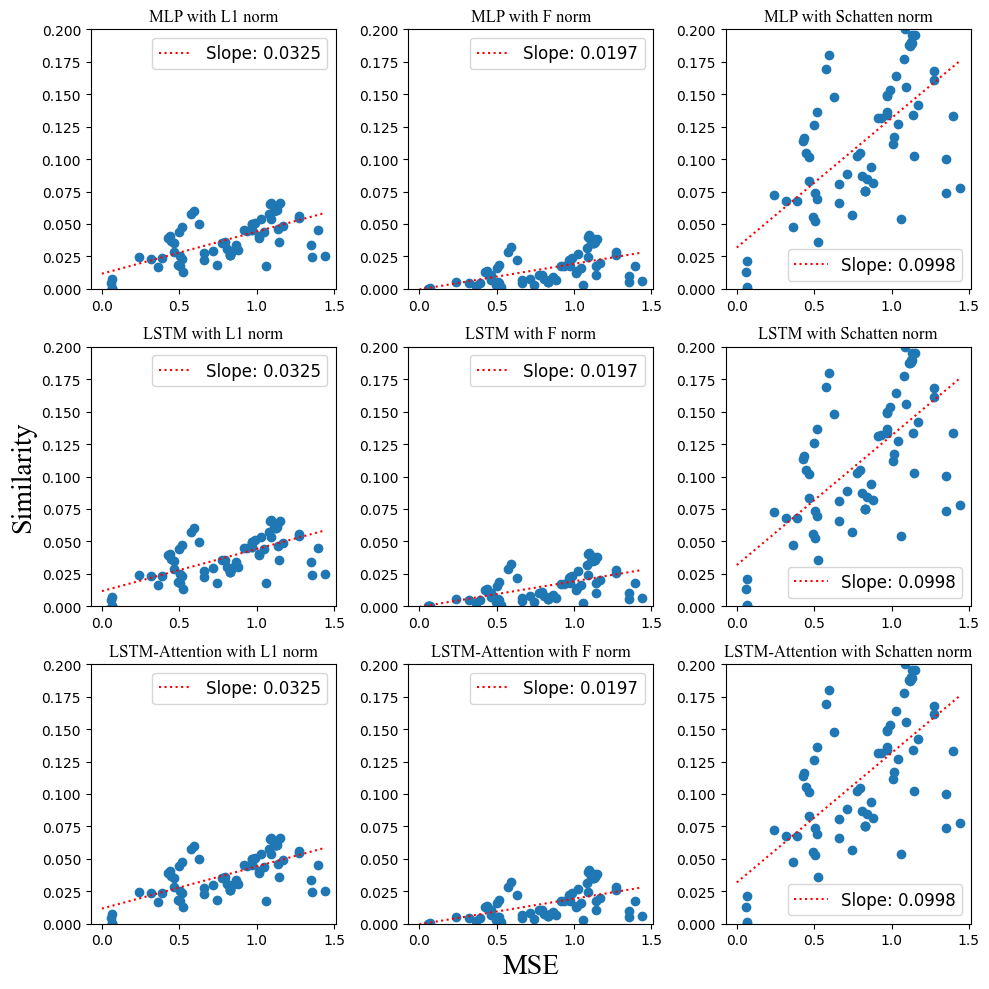

In [10]:
font1={'family':'Times New Roman','weight':'normal','size':20}
font2={'family':'Times New Roman','weight':'normal','size':12}

fig,ax=plt.subplots(3,3,figsize=(10,10))
ik=0
for i in DATA.keys():
    if i == 'MLP' or i == 'LSTM':
        model_name=i
    else:
        model_name='LSTM-Attention'
    for j in range(3):
        
        if j ==0:
            dis='similarL1'
            dis_name='L1 norm'
        elif j==1:
            dis='similarLF'
            dis_name='F norm'
        else:
            dis='similarLS'
            dis_name='Schatten norm'
        
        X,Y=[],[]
        for k in DATA[i]['mse'].keys():
            X.append(DATA[i]['mse'][k])
            Y.append(np.abs(DATA[i][dis][k]))

        X,Y=np.array(X).reshape((-1,1)),np.array(Y).reshape((-1,1))
        reg = LR().fit(X,Y)
        yhat = reg.predict(X)
        print(reg.coef_)

        coef = reg.coef_
        inter = reg.intercept_

        x=np.arange(0,np.max(X),0.001)
        y=coef*x+inter

        pltdata=[]
        for k in dataMLP['mse'].keys():
            pltdata.append([DATA[i]['mse'][k],np.abs(DATA[i][dis][k])])
        pltdata=np.array(pltdata)
        ax[ik,j].scatter(pltdata[:,0],pltdata[:,1])
        ax[ik,j].plot(x,y[0],'r:',label='Slope: '+str(np.round(coef[0][0],4)))
        ax[ik,j].set_title(model_name+' with '+dis_name,font=font2)
        ax[ik,j].legend(fontsize=12)
        ax[ik,j].set_ylim([0,0.2])
        
        if ik==2 and j==1:
            ax[ik,j].set_xlabel('MSE',font=font1)
        if ik==1 and j==0:
            ax[ik,j].set_ylabel('Similarity',font=font1)
    ik+=1
fig.tight_layout(h_pad=1,w_pad=1)
os.chdir(os.path.pardir)
print(os.getcwd())
plt.savefig('./fig8.tif',dpi=100)
os.chdir('/Users/tianwenchong/Desktop/Text12-Koopman-WQ/Step4_Compare')

# 相关性分析

In [13]:
tem=[]
for i in DATA.keys():
    if i == 'MLP' or i == 'LSTM':
        model_name=i
    else:
        model_name='LSTM-Attention'
    
    for corit in ['pearson','spearman']:
        line = []
        for j in range(3):
            
            if j ==0:
                dis='similarL1'
                dis_name='L1 norm'
            elif j==1:
                dis='similarLF'
                dis_name='F norm'
            else:
                dis='similarLS'
                dis_name='Schatten norm'
            
            X,Y=[],[]
            for k in DATA[i]['mse'].keys():
                X.append(DATA[i]['mse'][k])
                Y.append(np.abs(DATA[i][dis][k]))

            #X,Y=np.array(X).reshape((-1,1)),np.array(Y).reshape((-1,1))
            dd = {'mse':X,'sim':Y}
            
            d = pd.DataFrame(dd).corr(corit)
            line.append(d.iloc[0,1])
        tem.append(line)
os.chdir(os.path.pardir)
print(os.getcwd())
pd.DataFrame(tem).to_csv('./corr.csv')
os.chdir('/Users/tianwenchong/Desktop/Text12-Koopman-WQ/Step4_Compare')

/Users/tianwenchong/Desktop/Text12-Koopman-WQ


font1={'family':'Times New Roman','weight':'normal','size':20}
font2={'family':'Times New Roman','weight':'normal','size':12}

fig,ax=plt.subplots(1,3,figsize=(15,5))
ik=0

color=['r','b','g']

for i in DATA.keys():
    if i == 'MLP' or i == 'LSTM':
        model_name=i
    else:
        model_name='LSTM-Attention'
    for j in range(3):
        
        if j ==0:
            dis='similarL1'
            dis_name='L1 norm'
        elif j==1:
            dis='similarLF'
            dis_name='F norm'
        else:
            dis='similarLS'
            dis_name='Schatten norm'
        
        X,Y=[],[]
        for k in DATA[i]['mse'].keys():
            X.append(DATA[i]['mse'][k])
            Y.append(np.abs(DATA[i][dis][k]))

        X,Y=np.array(X).reshape((-1,1)),np.array(Y).reshape((-1,1))
        reg = LR().fit(X,Y)
        yhat = reg.predict(X)
        print(reg.coef_)

        coef = reg.coef_
        inter = reg.intercept_

        x=np.arange(0,np.max(X),0.001)
        y=coef*x+inter

        pltdata=[]
        for k in dataMLP['mse'].keys():
            pltdata.append([DATA[i]['mse'][k],np.abs(DATA[i][dis][k])])
        pltdata=np.array(pltdata)
        ax[ik].scatter(pltdata[:,0],pltdata[:,1],c=color[j])
        ax[ik].plot(x,y[0],color[j]+':',label='Slope based on '+dis_name+': '+str(np.round(coef[0][0],4)))
        ax[ik].set_title(model_name+' with '+dis_name,font=font2)
        ax[ik].legend(fontsize=12)
        ax[ik].set_ylim([0,0.2])
        
        ax[ik].set_xlabel('MSE',font=font1)
        ax[ik].set_ylabel('Similarity',font=font1)
    ik+=1
fig.tight_layout(h_pad=1,w_pad=1)
os.chdir(os.path.pardir)
print(os.getcwd())
plt.savefig('./fig8.tif',dpi=100)
os.chdir('/Users/tianwenchong/Desktop/Text12-Koopman-WQ/Step4_Compare')